# Logistic Regression

Let's see how simple it is to apply a logistic regression with Concrete-ML.

### Let's start by importing some libraries to develop our logistic regression model

In [1]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression
from sklearn.model_selection import train_test_split

from concrete.ml.sklearn import LogisticRegression as ConcreteLogisticRegression

### And some helpers for visualization

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
from IPython.display import display

### We need a training set, specifically a handcrafted one for simplicity. Let's also define a grid on which to test our classifier

In [3]:
X, y = make_classification(
    n_features=2,
    n_redundant=0,
    n_informative=2,
    random_state=2,
    n_clusters_per_class=1,
    n_samples=100,
)

rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)

b_min = np.min(X, axis=0)
b_max = np.max(X, axis=0)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

x_test_grid, y_test_grid = np.meshgrid(
    np.linspace(b_min[0], b_max[0], 30), np.linspace(b_min[1], b_max[1], 30)
)
x_grid_test = np.vstack([x_test_grid.ravel(), y_test_grid.ravel()]).transpose()

### Train a logistic regression with sklearn on the training set

In [4]:
logreg = SklearnLogisticRegression()
logreg.fit(x_train, y_train)

LogisticRegression()

### Visualize our data set and initial classifier to get a grasp on it

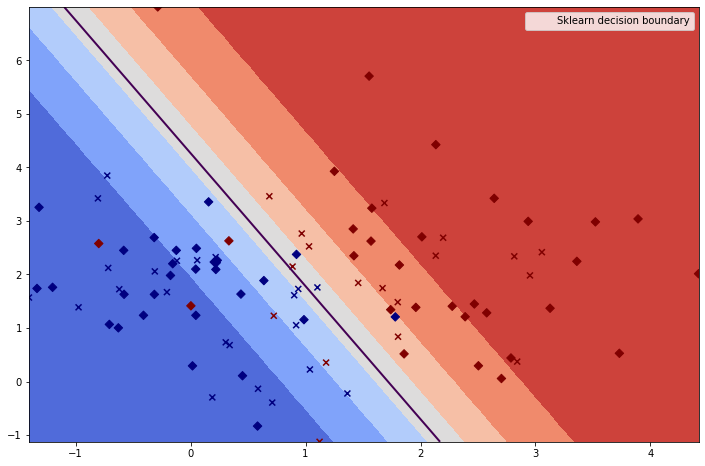

In [5]:
y_score_grid = logreg.predict_proba(x_grid_test)[:, 1]

plt.ioff()
plt.clf()
fig, ax = plt.subplots(1, figsize=(12, 8))
fig.patch.set_facecolor("white")
ax.contourf(x_test_grid, y_test_grid, y_score_grid.reshape(x_test_grid.shape), cmap="coolwarm")
CS1 = ax.contour(
    x_test_grid,
    y_test_grid,
    y_score_grid.reshape(x_test_grid.shape),
    levels=[0.5],
    linewidths=2,
)
CS1.collections[0].set_label("Sklearn decision boundary")
ax.scatter(x_train[:, 0], x_train[:, 1], c=y_train, marker="D", cmap="jet")
ax.scatter(x_test[:, 0], x_test[:, 1], c=y_test, marker="x", cmap="jet")
ax.legend(loc="upper right")
display(fig)

### Calibrate the model for quantization using both training and test data


In [6]:
q_logreg = ConcreteLogisticRegression(n_bits={"inputs": 5, "weights": 2})
q_logreg.fit(x_train, y_train)

### Now, we can compile our model to FHE, taking all of our dataset as the possible inputset

In [7]:
q_logreg.compile(x_train)

### Time to make some predictions, first in the clear

In [8]:
# Test the original classifier
y_pred_test = np.asarray(logreg.predict(x_test))

# Now that the model is quantized, predict on the test set
q_y_score_test = q_logreg.predict_proba(x_test)[:, 1]
q_y_pred_test = q_logreg.predict(x_test)

# Predict sklearn classifier probabilities on the domain
y_score_grid = logreg.predict_proba(x_grid_test)[:, 1]

# Predict quantized classifier probabilities on the whole domain to plot contours
q_y_score_grid = q_logreg.predict_proba(x_grid_test)[:, 1]
q_y_pred_grid = q_logreg.predict(x_grid_test)

### Predict using the quantized FHE classifier

In [9]:
q_y_pred_fhe = q_logreg.predict(x_test, execute_in_fhe=True)

### Aggregate accuracies for all the versions of the classifier

In [10]:
sklearn_acc = np.sum(y_pred_test == y_test) / len(y_test) * 100
quantized_accuracy = (q_y_pred_test == y_test).mean() * 100
homomorphic_accuracy = (q_y_pred_fhe == y_test).mean() * 100
difference = abs(homomorphic_accuracy - quantized_accuracy)

print(f"Sklearn accuracy: {sklearn_acc:.4f}")
print(f"Non Homomorphic Accuracy: {quantized_accuracy:.4f}")
print(f"Homomorphic Accuracy: {homomorphic_accuracy:.4f}")
print(f"Difference Percentage: {difference:.2f}%")

Sklearn accuracy: 90.0000
Non Homomorphic Accuracy: 87.5000
Homomorphic Accuracy: 87.5000
Difference Percentage: 0.00%


### Plot the results of both the original and FHE versions of the classifier, showing classification errors induced by quantization with a red circle

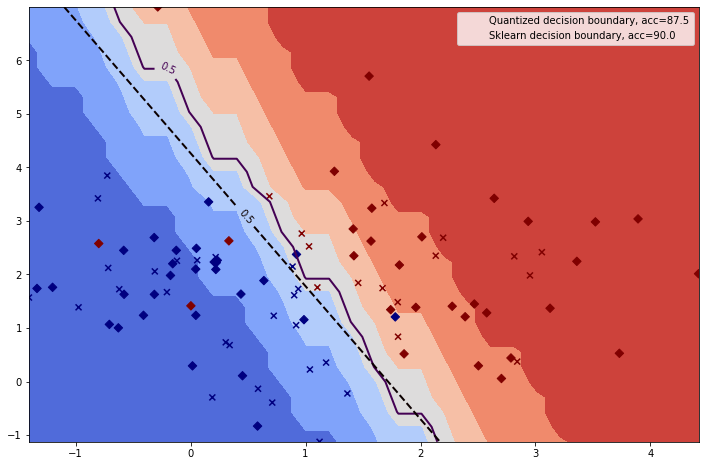

In [11]:
plt.clf()
fig, ax = plt.subplots(1, figsize=(12, 8))
fig.patch.set_facecolor("white")
ax.contourf(x_test_grid, y_test_grid, q_y_score_grid.reshape(x_test_grid.shape), cmap="coolwarm")
CS1 = ax.contour(
    x_test_grid,
    y_test_grid,
    q_y_score_grid.reshape(x_test_grid.shape),
    levels=[0.5],
    linewidths=2,
)
ax.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap="jet", marker="D")
ax.scatter(x_test[:, 0], x_test[:, 1], c=q_y_pred_test, cmap="jet", marker="x")
CS2 = ax.contour(
    x_test_grid,
    y_test_grid,
    y_score_grid.reshape(x_test_grid.shape),
    levels=[0.5],
    linewidths=2,
    linestyles="dashed",
    cmap="hot",
)
ax.clabel(CS1, CS1.levels, inline=True, fontsize=10)
ax.clabel(CS2, CS2.levels, inline=True, fontsize=10)
CS1.collections[0].set_label(f"Quantized decision boundary, acc={homomorphic_accuracy:.1f}")
CS2.collections[0].set_label(f"Sklearn decision boundary, acc={sklearn_acc:.1f}")
ax.legend(loc="upper right")
display(fig)